In [2]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM 

from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

In [3]:
!pwd

/kaggle/working


In [4]:
def generate_data(path):
  # Function that splits training path and annotations in 2 different lists.
  _path = []
  _label = []
  with open(path) as _data:
    for line in _data:
      temp = np.array(line.split())
      _path.append(temp[0])
      _label.append(temp[1])
  return _path, _label

In [5]:
train_path, train_label = generate_data("/kaggle/input/hindi-words-dataset/train.txt")

In [6]:
val_path, val_label = generate_data("/kaggle/input/hindi-words-dataset/val.txt")

In [8]:
# Code that generates a list of all the available characters in the dataset.
temp_vocab = []
with open("/kaggle/input/hindi-words-dataset/hindi_vocab.txt") as hindi_voc:
  for char in hindi_voc:
    temp = np.array(char.split("\n"))
    temp_vocab.append(temp[0])
vocab = set("".join(map(str, temp_vocab)))
print(sorted(vocab))
# print(len(vocab))

['-', 'ँ', 'ं', 'ः', 'ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॐ', '॑', '॒', '॓', '॔', 'क़', 'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', 'य़', 'ॠ', 'ॡ', 'ॢ', '।', '॥', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '॰', 'ॱ', 'ॲ', 'ॻ', 'ॼ', 'ॽ', 'ॾ', 'ॿ']


In [9]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []

    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return dig_lst

In [10]:
len(train_path), len(val_path)

(69853, 12708)

In [11]:
max_label_len = max([len(str(text)) for text in temp_vocab])
max_label_len

23

In [12]:
class My_Generator(Sequence):


  def __init__(self, image_filenames, labels, batch_size):
    self.image_filenames, self.labels = image_filenames, labels
    self.batch_size = batch_size

  def __len__(self):
    return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

    images = []
    training_txt = []
    train_label_length = []
    train_input_length = []

    for im_path, text in zip(batch_paths, batch_texts):
        try:
            text = str(text).strip()
            img = cv2.cvtColor(cv2.imread("/kaggle/input/hindi-words-dataset/HindiSeg/" + im_path), cv2.COLOR_BGR2GRAY)

            ### actually returns h, w
            h, w = img.shape

            ### if height less than 32
            if h < 32:
                add_zeros = np.ones((32-h, w)) * 255
                img = np.concatenate((img, add_zeros))
                h = 32

            ## if width less than 128
            if w < 128:
                add_zeros = np.ones((h, 128-w)) * 255
                img = np.concatenate((img, add_zeros), axis=1)
                w = 128

            ### if width is greater than 128 or height greater than 32
            if w > 128 or h > 32:
                img = cv2.resize(img, (128, 32))

                img = np.expand_dims(img , axis = 2)

                # Normalize each image
                img = img / 255.

                images.append(img)
                training_txt.append(encode_to_labels(text))
                train_label_length.append(len(text))
                train_input_length.append(31)
        except:
            pass


    images = tf.convert_to_tensor(images)
    padded_training_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=0)
    training_txt = tf.convert_to_tensor(padded_training_txt)
    train_input_length = tf.convert_to_tensor(train_input_length)
    train_label_length = tf.convert_to_tensor(train_label_length)

    # Return as a tuple
    return (images, training_txt, train_input_length, train_label_length), tf.zeros(tf.shape(images)[0])

In [13]:
batch_size = 256
train_generator = My_Generator(train_path, train_label, batch_size)
val_generator = My_Generator(val_path, val_label, batch_size)

In [14]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [15]:
act_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 128, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 32, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 32, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 32, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 32, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 32, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 32, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 32, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 31, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 31, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 31, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31, 113)        │        29,041 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,953 (2.94 MB)

 Trainable params: 771,697 (2.94 MB)

 Non-trainable params: 256 (1.00 KB)

In [16]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func,
                  output_shape=(1,),
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [17]:
file_path = "Hindi_OCR_Model.keras"

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, 
              optimizer='Adam',
              metrics=['accuracy'])  # Adding accuracy as a metric

checkpoint = ModelCheckpoint(filepath=file_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

callbacks_list = [checkpoint]

In [20]:
epochs = 25

Hindi = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = len(train_path) // batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_path) // batch_size,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True)

Epoch 1/25
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0000e+00 - loss: 20.8758
Epoch 1: val_loss did not improve from 11.69756
272/272 ━━━━━━━━━━━━━━━━━━━━ 863s 3s/step - accuracy: 0.0000e+00 - loss: 20.8733 - val_accuracy: 0.0000e+00 - val_loss: 20.6981
Epoch 2/25
  1/272 ━━━━━━━━━━━━━━━━━━━━ 38s 141ms/step - accuracy: 0.0000e+00 - loss: 18.5370
Epoch 2: val_loss improved from 11.69756 to 11.53182, saving model to Hindi_OCR_Model.keras
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0000e+00 - loss: 9.3026 - val_accuracy: 0.0000e+00 - val_loss: 11.5318
Epoch 3/25
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0000e+00 - loss: 17.3333
Epoch 3: val_loss did not improve from 11.53182
272/272 ━━━━━━━━━━━━━━━━━━━━ 861s 3s/step - accuracy: 0.0000e+00 - loss: 17.3272 - val_accuracy: 0.0000e+00 - val_loss: 14.2802
Epoch 4/25
  1/272 ━━━━━━━━━━━━━━━━━━━━ 43s 160ms/step - accuracy: 0.0000e+00 - loss: 12.6589
Epoch 4: val_loss improved from 11.53182 to 7.81203, saving m

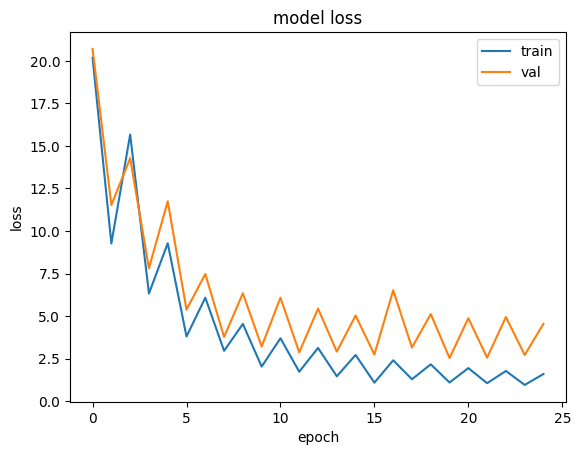

In [21]:
plt.plot(Hindi.history['loss'])
plt.plot(Hindi.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

<Figure size 640x480 with 0 Axes>

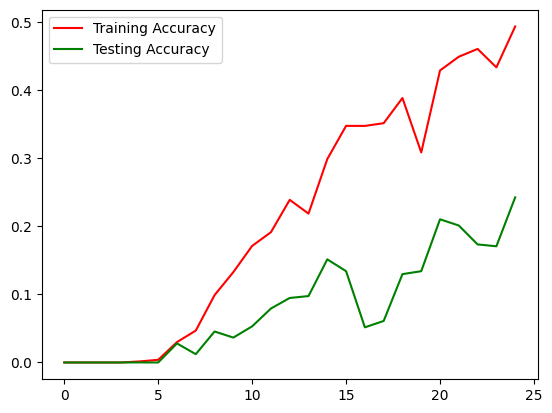

<Figure size 640x480 with 0 Axes>

In [22]:
accu=Hindi.history['accuracy']
val_acc=Hindi.history['val_accuracy']

epochs=range(len(accu)) #No. of epochs

import matplotlib.pyplot as plt
plt.plot(epochs,accu,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')
plt.legend()
plt.figure()